# DAQL for BipedalWalker

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('BipedalWalker-v2')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [4]:
# state = env.reset()
# batch = []
# for _ in range(1111):
#     #env.render()
#     action = env.action_space.sample()
#     next_state, reward, done, _ = env.step(action) # take a random action
#     batch.append([state, action, next_state, reward, float(done)])
#     state = next_state
#     if done:
#         state = env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
import numpy as np
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print('states:', np.max(np.array(states)), np.min(np.array(states)))
# print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

In [8]:
# env.action_space.high, env.action_space.low

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size, action_size):
    #states = tf.placeholder(tf.float32, [None, *state_shape], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.float32, [None, action_size], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_state')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    return states, actions, next_states, rewards, dones

In [10]:
# a = act(s)
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False, trainable=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size, trainable=trainable)
        bn1 = tf.layers.batch_normalization(h1, training=training, trainable=trainable)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size, trainable=trainable)
        bn2 = tf.layers.batch_normalization(h2, training=training, trainable=trainable)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size, trainable=trainable)        
        pred = tf.tanh(logits)
        return pred

In [11]:
# s', Q = env(s, a)
def discriminator(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False, 
                  trainable=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size, trainable=trainable)
        bn1 = tf.layers.batch_normalization(h1, training=training, trainable=trainable)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size, trainable=trainable)
        bn2 = tf.layers.batch_normalization(h2, training=training, trainable=trainable)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        next_states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=trainable)        
        Qlogits = tf.layers.dense(inputs=next_states_logits, units=1, trainable=False)        
        return next_states_logits, Qlogits

In [19]:
def model_loss(action_size, hidden_size, state_size, gamma,
               states, actions, next_states, rewards, dones):
    #########################################
    actions_pred = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gen_next_states, gQlogits = discriminator(actions=actions_pred, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size)
    gQs = tf.reshape(gQlogits, shape=[-1])
    print('gQlogits.shape, gQs.shape:', gQlogits.shape, gQs.shape)
    gloss = -tf.reduce_mean(gQs)
    gloss += -tf.reduce_mean(tf.reduce_sum(tf.square(gen_next_states - next_states), axis=1))
    ########################################
    next_actions_pred = generator(states=next_states, hidden_size=hidden_size, action_size=action_size, 
                                  trainable=False, reuse=True)
    _, nextQlogits = discriminator(actions=next_actions_pred, states=next_states, hidden_size=hidden_size,
                              action_size=action_size, state_size=state_size, 
                              trainable=False, reuse=True)
    nextQs = tf.reshape(nextQlogits, shape=[-1])
    targetQs = gamma * nextQs * (1-dones)
    print('nextQlogits.shape, nextQs.shape, targetQs.shape:', nextQlogits.shape, nextQs.shape, targetQs.shape)
    ###########################################
    next_states_pred, Qlogits = discriminator(actions=actions, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size, reuse=True)
    Qs = tf.reshape(Qlogits, shape=[-1])
    print('Qs.shape, Qlogits.shape:', Qs.shape, Qlogits.shape)
    rewards_in = Qs - targetQs
    print('rewards_in.shape, rewards.shape:', rewards_in.shape, rewards.shape)
    dloss = tf.reduce_mean(tf.square(rewards_in - rewards))
    dloss += tf.reduce_mean(tf.reduce_sum(tf.square(next_states_pred - next_states), axis=1))
    return actions_pred, gloss, dloss

In [20]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate, gamma):
        
        # Model inputs
        self.states, self.actions, self.next_states, self.rewards, self.dones = model_input(
            state_size=state_size, action_size=action_size)

        # Model loss/objective
        self.actions_pred, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size, gamma=gamma,
            states=self.states, actions=self.actions, next_states=self.next_states,
            rewards=self.rewards, dones=self.dones)
        
        # Model optimization/update
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

In [22]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [24]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 24
action_size = 4
hidden_size = 24*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size == one episode size is 1000/int(1e3) steps
gamma = 0.99                   # future reward discount

In [25]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

gQlogits.shape, gQs.shape: (?, 1) (?,)
nextQlogits.shape, nextQs.shape, targetQs.shape: (?, 1) (?,) (?,)
Qs.shape, Qlogits.shape: (?,) (?, 1)
rewards_in.shape, rewards.shape: (?,) (?,)


In [26]:
env.observation_space.high, env.observation_space.low, env.observation_space, \
env.action_space.high, env.action_space.low, env.action_space, \
env.reward_range

(array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       dtype=float32),
 array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf], dtype=float32),
 Box(24,),
 array([1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1.], dtype=float32),
 Box(4,),
 (-inf, inf))

In [ ]:
state = env.reset()
for each_step in range(memory_size):
    action = env.action_space.sample() # randomness
    action = np.clip(action, -1, 1) # clipped: [-1, +1]
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        print('Progress:', each_step/memory_size)
        state = env.reset()

Progress: 0.01599
Progress: 0.01693
Progress: 0.03293
Progress: 0.04893
Progress: 0.06493
Progress: 0.06578
Progress: 0.06675
Progress: 0.0675
Progress: 0.0681
Progress: 0.06899
Progress: 0.06984
Progress: 0.07073
Progress: 0.0715
Progress: 0.07216
Progress: 0.07257
Progress: 0.08857
Progress: 0.08964
Progress: 0.09042
Progress: 0.09123
Progress: 0.10723
Progress: 0.10798
Progress: 0.10871
Progress: 0.10973
Progress: 0.1103
Progress: 0.1263
Progress: 0.1423
Progress: 0.14299
Progress: 0.14358
Progress: 0.14427
Progress: 0.14517
Progress: 0.16117
Progress: 0.16188
Progress: 0.16259
Progress: 0.17859
Progress: 0.17923
Progress: 0.19523
Progress: 0.19607
Progress: 0.19684
Progress: 0.19759
Progress: 0.21359
Progress: 0.21427
Progress: 0.21536
Progress: 0.21607
Progress: 0.21693
Progress: 0.23293
Progress: 0.24893
Progress: 0.24979
Progress: 0.25028
Progress: 0.25113
Progress: 0.25204
Progress: 0.26804
Progress: 0.28404
Progress: 0.28545
Progress: 0.30145
Progress: 0.30199
Progress: 0.3031

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
len(memory.buffer), memory.buffer.maxlen

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            env.render()
            
            action_pred = sess.run(model.actions_pred, feed_dict={model.states: state.reshape([1, -1])})
            noise = np.random.normal(loc=0, scale=0.01, size=action_size) # randomness
            action = action_pred.reshape([-1]) + noise
            #print(action.shape, action_logits.shape, noise.shape)
            action = np.clip(action, -1, 1) # clipped
            
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state
            
            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            feed_dict = {model.states: states, 
                         model.actions: actions,
                         model.next_states: next_states, 
                         model.rewards: rewards, 
                         model.dones: dones}
            dloss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        # Did not solve the environment. 
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        if np.mean(episode_reward) >= 300:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:-116.2240 R:-116.2240 gloss:-8.4344 dloss:23.1279
Episode:1 meanR:-129.1552 R:-142.0863 gloss:-7.0493 dloss:17.6875
Episode:2 meanR:-126.6837 R:-121.7407 gloss:-5.6654 dloss:11.1291
Episode:3 meanR:-125.6977 R:-122.7399 gloss:-5.4225 dloss:8.5475
Episode:4 meanR:-125.1436 R:-122.9270 gloss:-5.1077 dloss:22.5569
Episode:5 meanR:-124.7696 R:-122.8997 gloss:-4.9629 dloss:12.9203
Episode:6 meanR:-124.4796 R:-122.7396 gloss:-4.7713 dloss:15.1887
Episode:7 meanR:-124.2563 R:-122.6929 gloss:-4.4648 dloss:12.5843
Episode:8 meanR:-124.0787 R:-122.6578 gloss:-4.3517 dloss:7.7359
Episode:9 meanR:-123.9344 R:-122.6360 gloss:-4.1904 dloss:5.2134
Episode:10 meanR:-123.8206 R:-122.6826 gloss:-4.1285 dloss:19.3454
Episode:11 meanR:-123.7216 R:-122.6332 gloss:-3.9284 dloss:9.7338
Episode:12 meanR:-123.6520 R:-122.8160 gloss:-3.9041 dloss:12.0962
Episode:13 meanR:-123.5940 R:-122.8404 gloss:-3.8135 dloss:19.1121
Episode:14 meanR:-123.5516 R:-122.9573 gloss:-3.7449 dloss:7.2135
Episode:15

Episode:123 meanR:-123.6894 R:-123.5607 gloss:-3.8999 dloss:15.9428
Episode:124 meanR:-123.6855 R:-123.6134 gloss:-3.9115 dloss:21.8749
Episode:125 meanR:-123.6811 R:-123.5724 gloss:-4.0114 dloss:30.7017
Episode:126 meanR:-123.6779 R:-123.6558 gloss:-4.0252 dloss:27.4416
Episode:127 meanR:-123.6740 R:-123.6235 gloss:-4.0893 dloss:19.9581
Episode:128 meanR:-123.6746 R:-123.7635 gloss:-4.0764 dloss:11.1950
Episode:129 meanR:-123.6754 R:-123.6764 gloss:-4.0984 dloss:20.8109
Episode:130 meanR:-123.6747 R:-123.6166 gloss:-4.0109 dloss:24.0019
Episode:131 meanR:-123.6744 R:-123.5685 gloss:-4.1087 dloss:28.5287
Episode:132 meanR:-123.6725 R:-123.5834 gloss:-4.1169 dloss:22.8979
Episode:133 meanR:-123.6710 R:-123.5579 gloss:-4.2466 dloss:27.7336
Episode:134 meanR:-123.6709 R:-123.6442 gloss:-4.1964 dloss:28.2920
Episode:135 meanR:-123.6695 R:-123.6064 gloss:-4.1204 dloss:26.2635
Episode:136 meanR:-123.6737 R:-123.6041 gloss:-4.2088 dloss:31.1622
Episode:137 meanR:-123.6754 R:-123.6626 gloss:-4

Episode:244 meanR:-124.7105 R:-125.4661 gloss:-6.1745 dloss:19.7319
Episode:245 meanR:-124.7256 R:-125.1202 gloss:-6.6806 dloss:26.3108
Episode:246 meanR:-124.7418 R:-125.3896 gloss:-6.3415 dloss:29.8438
Episode:247 meanR:-124.7590 R:-125.3047 gloss:-6.2688 dloss:30.1823
Episode:248 meanR:-124.7766 R:-125.2719 gloss:-5.9587 dloss:24.9616
Episode:249 meanR:-124.7999 R:-126.0493 gloss:-7.0681 dloss:28.1839
Episode:250 meanR:-124.9448 R:-126.3985 gloss:-5.7351 dloss:14.8459
Episode:251 meanR:-124.9524 R:-126.5466 gloss:-6.6105 dloss:29.9083
Episode:252 meanR:-124.9592 R:-126.3295 gloss:-6.5397 dloss:32.1731
Episode:253 meanR:-124.9674 R:-126.4378 gloss:-6.0613 dloss:35.6211
Episode:254 meanR:-124.9622 R:-125.8477 gloss:-6.1074 dloss:24.9558
Episode:255 meanR:-124.9464 R:-124.6450 gloss:-6.9786 dloss:32.1751
Episode:256 meanR:-124.9291 R:-124.5283 gloss:-6.2823 dloss:20.4949
Episode:257 meanR:-124.9303 R:-125.8654 gloss:-6.5790 dloss:26.4196
Episode:258 meanR:-124.9180 R:-124.4965 gloss:-6

Episode:365 meanR:-125.0476 R:-124.7891 gloss:-9.2845 dloss:36.8097
Episode:366 meanR:-125.0434 R:-124.7529 gloss:-10.1316 dloss:35.9618
Episode:367 meanR:-125.0436 R:-124.6039 gloss:-9.4683 dloss:37.6246
Episode:368 meanR:-125.0381 R:-124.6296 gloss:-9.6743 dloss:35.6278
Episode:369 meanR:-125.0415 R:-124.8046 gloss:-10.1227 dloss:29.3611
Episode:370 meanR:-125.0404 R:-124.5958 gloss:-9.4907 dloss:20.9346
Episode:371 meanR:-125.0431 R:-124.9205 gloss:-8.9871 dloss:31.2203
Episode:372 meanR:-125.0413 R:-124.7652 gloss:-8.9504 dloss:23.7450
Episode:373 meanR:-125.0437 R:-124.6224 gloss:-8.6269 dloss:18.9523
Episode:374 meanR:-125.0420 R:-124.8737 gloss:-9.8509 dloss:35.5956
Episode:375 meanR:-125.0381 R:-124.7143 gloss:-10.0608 dloss:31.1354
Episode:376 meanR:-125.0331 R:-124.6990 gloss:-9.7204 dloss:32.4081
Episode:377 meanR:-125.0313 R:-124.7976 gloss:-8.8889 dloss:25.5275
Episode:378 meanR:-125.0274 R:-124.6876 gloss:-10.6079 dloss:24.6585
Episode:379 meanR:-125.0236 R:-124.7228 glos

Episode:485 meanR:-124.9083 R:-124.6761 gloss:-10.8608 dloss:30.7471
Episode:486 meanR:-124.9060 R:-124.6377 gloss:-9.6010 dloss:24.1292
Episode:487 meanR:-124.9044 R:-124.6762 gloss:-10.6470 dloss:38.2250
Episode:488 meanR:-124.9043 R:-124.7143 gloss:-10.2142 dloss:33.7060
Episode:489 meanR:-124.9033 R:-124.5757 gloss:-10.8988 dloss:39.3166
Episode:490 meanR:-124.9019 R:-124.4735 gloss:-9.9817 dloss:24.4638
Episode:491 meanR:-124.9030 R:-124.8976 gloss:-9.7410 dloss:30.3617
Episode:492 meanR:-124.9064 R:-125.1650 gloss:-11.5451 dloss:34.2839
Episode:493 meanR:-124.9191 R:-126.1214 gloss:-12.1739 dloss:39.7271
Episode:494 meanR:-124.9293 R:-125.8711 gloss:-10.9706 dloss:34.3320
Episode:495 meanR:-124.9454 R:-125.8054 gloss:-12.8902 dloss:37.4714
Episode:496 meanR:-124.9586 R:-126.2819 gloss:-12.7052 dloss:44.4076
Episode:497 meanR:-124.9675 R:-125.7896 gloss:-12.9993 dloss:35.9311
Episode:498 meanR:-124.9711 R:-125.2052 gloss:-11.6815 dloss:33.4940
Episode:499 meanR:-124.9798 R:-125.61

Episode:604 meanR:-124.6374 R:-124.0448 gloss:-12.7192 dloss:38.8817
Episode:605 meanR:-124.6363 R:-124.4807 gloss:-12.0507 dloss:32.8836
Episode:606 meanR:-124.6372 R:-124.5474 gloss:-13.5548 dloss:38.9773
Episode:607 meanR:-124.6403 R:-124.4934 gloss:-10.6307 dloss:36.0457
Episode:608 meanR:-124.6347 R:-124.0990 gloss:-12.2541 dloss:34.9688
Episode:609 meanR:-124.6370 R:-124.3845 gloss:-8.3488 dloss:27.5510
Episode:610 meanR:-124.6339 R:-124.5470 gloss:-11.8293 dloss:38.9087
Episode:611 meanR:-124.6311 R:-124.4357 gloss:-15.1552 dloss:54.3041
Episode:612 meanR:-124.6287 R:-124.4369 gloss:-15.7325 dloss:37.9961
Episode:613 meanR:-124.6292 R:-124.1377 gloss:-15.1602 dloss:37.4301
Episode:614 meanR:-124.6287 R:-124.5459 gloss:-15.6684 dloss:51.9840
Episode:615 meanR:-124.6273 R:-124.4095 gloss:-15.9655 dloss:44.5304
Episode:616 meanR:-124.6305 R:-124.3728 gloss:-13.6270 dloss:37.0738
Episode:617 meanR:-124.6339 R:-124.2073 gloss:-13.0992 dloss:38.9921
Episode:618 meanR:-124.6327 R:-124.

Episode:723 meanR:-124.3965 R:-124.1868 gloss:-14.8595 dloss:41.3212
Episode:724 meanR:-124.3991 R:-124.6692 gloss:-16.2846 dloss:52.2776
Episode:725 meanR:-124.2677 R:-111.3024 gloss:-15.6513 dloss:41.1758
Episode:726 meanR:-124.1456 R:-111.9815 gloss:-17.7227 dloss:49.6699
Episode:727 meanR:-124.4750 R:-157.0536 gloss:-16.8004 dloss:47.5946
Episode:728 meanR:-124.8924 R:-165.8081 gloss:-17.4998 dloss:48.6662
Episode:729 meanR:-125.2158 R:-156.2892 gloss:-16.2569 dloss:45.6715
Episode:730 meanR:-125.5347 R:-156.0450 gloss:-17.3867 dloss:47.4213
Episode:731 meanR:-125.6896 R:-139.4535 gloss:-17.9809 dloss:50.2252
Episode:732 meanR:-125.7301 R:-127.9572 gloss:-17.8906 dloss:51.3190
Episode:733 meanR:-125.7661 R:-127.5725 gloss:-19.5680 dloss:48.9108
Episode:734 meanR:-125.8833 R:-135.7246 gloss:-18.5295 dloss:46.6431
Episode:735 meanR:-125.8013 R:-115.7768 gloss:-20.0814 dloss:54.9391
Episode:736 meanR:-125.6954 R:-113.4992 gloss:-18.5818 dloss:50.8316
Episode:737 meanR:-125.6233 R:-116

Episode:842 meanR:-114.0382 R:-113.9442 gloss:-17.3816 dloss:59.9945
Episode:843 meanR:-113.9997 R:-115.8243 gloss:-17.6895 dloss:60.6348
Episode:844 meanR:-113.9744 R:-115.1952 gloss:-19.5307 dloss:59.0892
Episode:845 meanR:-113.9664 R:-114.0106 gloss:-16.3988 dloss:50.9225
Episode:846 meanR:-113.9769 R:-115.1683 gloss:-18.3906 dloss:62.3669
Episode:847 meanR:-113.9792 R:-114.7554 gloss:-17.9449 dloss:51.8776
Episode:848 meanR:-113.9874 R:-113.3355 gloss:-18.2058 dloss:50.6078
Episode:849 meanR:-114.0000 R:-114.2284 gloss:-16.1092 dloss:52.5698
Episode:850 meanR:-114.0381 R:-116.8094 gloss:-17.2952 dloss:46.7420
Episode:851 meanR:-114.0637 R:-116.7749 gloss:-16.4040 dloss:43.8965
Episode:852 meanR:-114.1170 R:-118.1501 gloss:-14.5442 dloss:52.5486
Episode:853 meanR:-114.1049 R:-114.3602 gloss:-17.8142 dloss:53.6984
Episode:854 meanR:-114.1399 R:-117.3620 gloss:-17.8455 dloss:67.6147
Episode:855 meanR:-114.1885 R:-117.5893 gloss:-17.8601 dloss:49.8304
Episode:856 meanR:-114.2732 R:-120

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

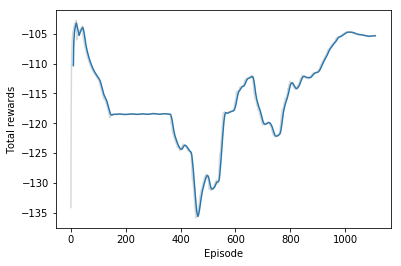

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

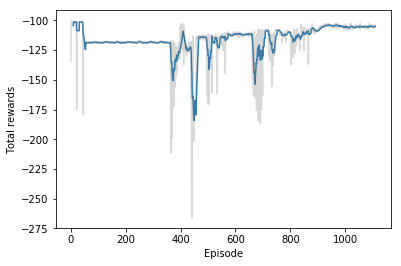

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

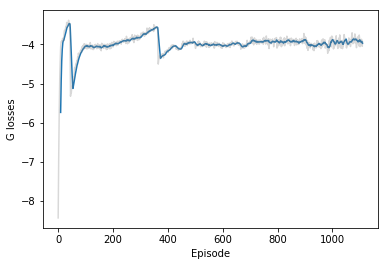

In [29]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

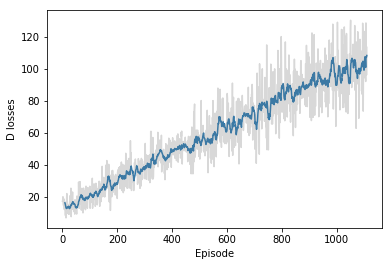

In [30]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [31]:
import gym
env = gym.make('BipedalWalker-v2')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            actions_pred = sess.run(model.actions_pred, feed_dict={model.states: state.reshape([1, -1])})
            action = action_pred.reshape([-1])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: -104.69566602519279


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.